In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm, wilcoxon, sem

# Load big CSV file
csvfile = '/home/dan/work/cclab/py/combined_datas.csv'
combined_df = pd.read_csv(csvfile)

# === Step 2: Define Styling and Plotting Parameters ===
plt.rcParams.update({
    "font.family": "sans-serif",
    "font.size": 10,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.edgecolor": "black",
    "axes.linewidth": 1,
    "xtick.direction": "out",
    "ytick.color": "black",
    "xtick.color": "black",
    "ytick.direction": "out",
    "figure.dpi": 100
})


# === Step 1: Classify Attention Condition ===
def classify_attention(row):
    if (row["Type"] == "Left" and row["StimTestType"] == 1) or (row["Type"] == "Right" and row["StimTestType"] == 2):
        return "Attend In"
    else:
        return "Attend Out"

# === Step 3: Function to Annotate Asterisk for Significance ===
def annotate_sig_strict(ax, x1, x2, y, p, height=0.05):
    if p < 0.05:
        ax.plot([x1, x1, x2, x2], [y, y + height, y + height, y], color='black', linewidth=1)
        if p < 0.001:
            sig = '***'
        elif p < 0.01:
            sig = '**'
        else:
            sig = '*'
        ax.text((x1 + x2) / 2, y + height + 0.01, sig, ha='center', va='bottom', fontsize=10)
       
# Step 3: d-prime helper
def compute_dprime(hit_rate, fa_rate):
    from scipy.stats import norm
    # Avoid extreme values
    hit_rate = np.clip(hit_rate, 1e-5, 1 - 1e-5)
    fa_rate = np.clip(fa_rate, 1e-5, 1 - 1e-5)
    return norm.ppf(hit_rate) - norm.ppf(fa_rate)

# === Step 4: Plotting Function with Wilcoxon Test ===
def plot_all_subjects_wilcoxon(response_type, data_subset):
    subjects = data_subset["Prefix"].unique()
    attentions = data_subset["Attention"].unique()

    for subject in subjects:
        for attention in attentions:
            subset = data_subset[
                (data_subset["Prefix"] == subject) &
                (data_subset["Attention"] == attention)
            ]
            if not subset.empty:
                fig, ax = plt.subplots(figsize=(3, 3))

                # Bar values
                grouped = subset.groupby("sciTrialType")["ReactionTime"]
                means = grouped.mean().reindex(fixed_trial_order)
                y_values = means.fillna(0)
                bar_colors = ["0.4" if not np.isnan(m) else "none" for m in means]

                # Draw bars
                ax.bar(
                    fixed_trial_order,
                    y_values,
                    color=bar_colors,
                    edgecolor="black",
                    linewidth=1
                )

                # Run Wilcoxon test between paired trials
                for a, b in comparison_pairs:
                    a_trials = subset[subset["sciTrialType"] == a]
                    b_trials = subset[subset["sciTrialType"] == b]
                    if not a_trials.empty and not b_trials.empty:
                        merged = pd.merge(
                            a_trials[pairing_keys + ["ReactionTime"]],
                            b_trials[pairing_keys + ["ReactionTime"]],
                            on=pairing_keys,
                            suffixes=("_a", "_b")
                        )
                        if len(merged) >= 2:
                            stat, pval = wilcoxon(merged["ReactionTime_a"], merged["ReactionTime_b"])
                            max_height = max(y_values[a], y_values[b])
                            annotate_sig_strict(ax, fixed_trial_order.index(a), fixed_trial_order.index(b), max_height, pval)

                # Final formatting
                ax.set_title(f"{response_type}\n{subject} - {attention}", fontsize=10)
                ax.set_ylabel("RT (s)")
                ax.set_xlabel("Trial Type")
                ax.set_ylim(0, y_values.max() * 1.5 if y_values.max() > 0 else 1)
                ax.tick_params(axis='x', labelrotation=0)
                plt.tight_layout()
                plt.show()
                plt.close()

# Step 4: Metric plotting function
def plot_metrics(metric_name, metric_dict):
    for subject, data_by_attn in metric_dict.items():
        for attention, rates in data_by_attn.items():
            y_values = [rates.get(trial_type, 0) for trial_type in ["HH", "HL", "LH", "LL"]]
            fig, ax = plt.subplots(figsize=(3, 3))
            ax.bar(
                ["HH", "HL", "LH", "LL"],
                y_values,
                color="0.4",
                edgecolor="black",
                linewidth=1
            )
            ax.set_title(f"{metric_name}\n{subject} - {attention}")
            ax.set_ylabel(metric_name)
            ax.set_xlabel("Trial Type")
            ax.set_ylim(0, max(y_values) * 1.5 if max(y_values) > 0 else 1)
            ax.tick_params(axis='x', labelrotation=0)
            plt.tight_layout()
            plt.show()
            plt.close()

# Step 5: Plotting Function
def plot_rt_by_type(response_type_label, data_subset):
    subjects = data_subset["Prefix"].unique()
    attentions = data_subset["Attention"].unique()

    for subject in subjects:
        for attention in attentions:
            subset = data_subset[
                (data_subset["Prefix"] == subject) &
                (data_subset["Attention"] == attention)
            ]
            if not subset.empty:
                fig, ax = plt.subplots(figsize=(3, 3))

                # Means for plotting
                grouped = subset.groupby("sciTrialType")["ReactionTime"]
                means = grouped.mean().reindex(fixed_trial_order)
                y_values = means.fillna(0)
                bar_colors = ["0.4" if not np.isnan(m) else "none" for m in means]

                # Bar plot
                ax.bar(
                    fixed_trial_order,
                    y_values,
                    color=bar_colors,
                    edgecolor="black",
                    linewidth=1
                )

                # Significance test
                for a, b in comparison_pairs:
                    a_trials = subset[subset["sciTrialType"] == a]
                    b_trials = subset[subset["sciTrialType"] == b]
                    if not a_trials.empty and not b_trials.empty:
                        merged = pd.merge(
                            a_trials[pairing_keys + ["ReactionTime"]],
                            b_trials[pairing_keys + ["ReactionTime"]],
                            on=pairing_keys,
                            suffixes=("_a", "_b")
                        )
                        if len(merged) >= 2:
                            stat, pval = wilcoxon(merged["ReactionTime_a"], merged["ReactionTime_b"])
                            max_height = max(y_values[a], y_values[b])
                            annotate_sig_strict(ax, fixed_trial_order.index(a), fixed_trial_order.index(b), max_height, pval)

                # Final formatting
                ax.set_title(f"{response_type_label}\n{subject} - {attention}")
                ax.set_ylabel("RT (s)")
                ax.set_xlabel("Trial Type")
                ax.set_ylim(0, y_values.max() * 1.5 if y_values.max() > 0 else 1)
                ax.tick_params(axis='x', labelrotation=0)
                plt.tight_layout()
                plt.show()
                plt.close()

# Plotting function
def plot_rt_group_level_final(df, stim_tf, attention_label, title, ylabel="RT (s)"):
    subset = df[(df["StimChangeTF"] == stim_tf) & (df["Attention"] == attention_label)]

    # Subject-level means
    subject_means = (
        subset.groupby(["Prefix", "sciTrialType"])["ReactionTime"]
        .mean()
        .unstack()
        .reindex(columns=fixed_trial_order)
    )

    # Compute means and SEM using only valid values
    # DJS - bug in errors computation below, fixed by line following
    means = subject_means.mean()
    #ERROR sem not defined: errors = subject_means.apply(lambda x: sem(x.dropna()), axis=0)
    errors = subject_means.sem()

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar(
        fixed_trial_order,
        means.values,
        yerr=errors.values,
        capsize=5,
        color="0.4",
        edgecolor="black",
        linewidth=1,
        error_kw=dict(lw=1, capthick=1, ecolor="black")
    )

    # Paired comparisons
    for a, b in [("HH", "HL"), ("LH", "LL")]:
        if a in subject_means.columns and b in subject_means.columns:
            a_vals = subject_means[a].dropna()
            b_vals = subject_means[b].dropna()
            if len(a_vals) >= 2 and len(b_vals) >= 2:
                stat, pval = wilcoxon(a_vals, b_vals)
                max_y = max(means[a] + errors[a], means[b] + errors[b])
                annotate_sig_strict(ax, fixed_trial_order.index(a), fixed_trial_order.index(b), max_y, pval)

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Trial Type")
    ax.set_ylim(0, (means + errors).max() * 1.5 if not np.isnan(means + errors).all() else 1)
    ax.tick_params(axis='x', labelrotation=0)
    plt.tight_layout()
    plt.show()
    plt.close()

# Plotting function
def plot_rt_group_dw(df, stim_tf, attention_label, title, ylabel="RT (s)"):
    subset = df[(df["StimChangeTF"] == stim_tf) & (df["Attention"] == attention_label)]

    subject_means = (
        subset.groupby(["Prefix", "sciTrialType"])["ReactionTime"]
        .mean()
        .unstack()
        .reindex(columns=fixed_trial_order)
    )

    # djs same fix as in other functions here. 
    means = subject_means.mean()
    # ERROR sem not defined: errors = subject_means.apply(lambda x: sem(x.dropna()), axis=0)
    errors = subject_means.sem()

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar(
        fixed_trial_order,
        means.values,
        yerr=errors.values,
        capsize=5,
        color="0.4",
        edgecolor="black",
        linewidth=1,
        error_kw=dict(lw=1, capthick=1, ecolor="black")
    )

    for a, b in [("HH", "HL"), ("LH", "LL")]:
        if a in subject_means.columns and b in subject_means.columns:
            a_vals = subject_means[a].dropna()
            b_vals = subject_means[b].dropna()
            if len(a_vals) >= 2 and len(b_vals) >= 2:
                try:
                    stat, pval = wilcoxon(a_vals, b_vals)
                    max_y = max(means[a] + errors[a], means[b] + errors[b])
                    annotate_sig_strict(ax, fixed_trial_order.index(a), fixed_trial_order.index(b), max_y, pval)
                except ValueError:
                    continue

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Trial Type")
    ax.set_ylim(0, (means + errors).max() * 1.5 if not np.isnan(means + errors).all() else 1)
    ax.tick_params(axis='x', labelrotation=0)
    plt.tight_layout()
    plt.show()
    plt.close()

# Plotting function
def plot_metric_group_with_stats(df, metric, attention_label, title, ylabel):
    subset = df[df["Attention"] == attention_label]
    subjects = subset["Prefix"].unique()

    values_by_type = {tt: [] for tt in fixed_trial_order}

    for subject in subjects:
        subject_data = subset[subset["Prefix"] == subject]
        for ttype in fixed_trial_order:
            trial_data = subject_data[subject_data["sciTrialType"] == ttype]
            detect_trials = trial_data[trial_data["StimChangeTF"] != 0]
            detect_right = detect_trials[detect_trials["Correctness"] == "Right"]
            reject_trials = trial_data[trial_data["StimChangeTF"] == 0]
            reject_right = reject_trials[reject_trials["Correctness"] == "Right"]

            if metric == "Detection" and len(detect_trials) > 0:
                values_by_type[ttype].append(len(detect_right) / len(detect_trials))
            elif metric == "Rejection" and len(reject_trials) > 0:
                values_by_type[ttype].append(len(reject_right) / len(reject_trials))
            elif metric == "dprime" and len(detect_trials) > 0 and len(reject_trials) > 0:
                hit_rate = len(detect_right) / len(detect_trials)
                fa_rate = 1 - (len(reject_right) / len(reject_trials))
                values_by_type[ttype].append(compute_dprime(hit_rate, fa_rate))

    means = [np.mean(values_by_type[t]) if values_by_type[t] else np.nan for t in fixed_trial_order]
    #djs error here without import of 'sem' from scipy.stats, fix is in top cell above
    errors = [sem(values_by_type[t]) if len(values_by_type[t]) > 1 else np.nan for t in fixed_trial_order]

    fig, ax = plt.subplots(figsize=(3, 3))
    ax.bar(
        fixed_trial_order,
        means,
        yerr=errors,
        capsize=5,
        color="0.4",
        edgecolor="black",
        linewidth=1,
        error_kw=dict(lw=1, capthick=1, ecolor="black")
    )

    # Significance asterisks
    def annotate_sig(ax, x1, x2, y, p, height=0.05):
        if p < 0.05:
            ax.plot([x1, x1, x2, x2], [y, y+height, y+height, y], color='black', linewidth=1)
            sig = '***' if p < 0.001 else '**' if p < 0.01 else '*'
            ax.text((x1+x2)/2, y + height + 0.01, sig, ha='center', va='bottom', fontsize=10)   

    for a, b in [("HH", "HL"), ("LH", "LL")]:
        a_vals = values_by_type[a]
        b_vals = values_by_type[b]
        diffs = [x - y for x, y in zip(a_vals, b_vals) if not np.isnan(x) and not np.isnan(y) and x != y]
        if len(diffs) >= 2:
            try:
                stat, pval = wilcoxon(a_vals, b_vals)
                max_y = max(means[fixed_trial_order.index(a)] + errors[fixed_trial_order.index(a)],
                            means[fixed_trial_order.index(b)] + errors[fixed_trial_order.index(b)])
                annotate_sig(ax, fixed_trial_order.index(a), fixed_trial_order.index(b), max_y, pval)
            except ValueError:
                continue

    ax.set_title(title)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Trial Type")
    ax.set_ylim(0, (np.array(means) + np.nan_to_num(errors)).max() * 1.5 if not np.isnan(means).all() else 1)
    ax.tick_params(axis='x', labelrotation=0)
    plt.tight_layout()
    plt.show()
    plt.close()


In [2]:
# # Flip trials
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', None)

# # File paths and metadata
# file_prefixes = ["flipGDSitongg", "flipGDTaylorr","flipGDYuxinn","flipGDJunn","flipGDMaitrii","flipGDDann","flipGDKatie","flipGDHannah","flipGDDanny","flipGDZexi","flipGDKeer","flipGDHeath","flipGDAnthony","flipGDHongyu"]
# file_paths = [f"C:/Users/joy/Desktop/MATLABdata/{prefix}{i}.csv" for prefix in file_prefixes for i in range(1, 17)]
# blocks = [1, 2, 3, 4, 5, 6,7,8,9,10,11,12,13,14,15,16]
# types = ["Left", "Right", "Left","Right",  "Left","Right", "Left","Right","Left", "Right", "Left","Right",  "Left","Right", "Left","Right"]

# # List to store data
# all_data = []

# # Process each file
# for i, file in enumerate(file_paths):
#     try:
#         # Read the CSV file
#         df = pd.read_csv(file)

#         # Add metadata columns
#         df["FileName"] = os.path.basename(file)  # Optional: Add file name
#         df["Prefix"] = file_prefixes[i // len(blocks)]  # Derive prefix dynamically
#         df["Block"] = blocks[i % len(blocks)]
#         df["Type"] = types[i % len(types)]
        
#         df = df[df["Started"] == 1]
#         df = df[df["iResp"] > -1]
#         df["Row"] = range(len(df))
#         df["Trials"] = df.index
#         df["Correctness"] = np.where(df["iResp"] != df["StimChangeTF"], "Wrong", "Right")
        
#         # Append to the list
#         all_data.append(df)
#     except FileNotFoundError:
#         print(f"File not found: {file}, skipping.")
#     except Exception as e:
#         print(f"Error processing {file}: {e}")

# # Concatenate all DataFrames into one
# if all_data:
#     combined_df = pd.concat(all_data, ignore_index=True)
#     print(f"All files concatenated into a single DataFrame with {len(combined_df)} rows.")
# else:
#     print("No data to concatenate.")

# # Output summary
# if 'combined_df' in locals():
#     print(combined_df.info())
#     print(combined_df.head())

# # Save to a new CSV (optional)
# output_path = "C:/Users/joy/Desktop/combined_datas.csv"
# combined_df.to_csv(output_path, index=False)
# print(f"Combined data saved to {output_path}")


# # In[5]:






trial_types = ["HH", "HL", "LH", "LL"]

In [3]:
# djs - ImagePairIndex between 1-20 were the "neutral" trials - meaning that both
# sides 1/2 are tested for each pair. 
# A column 'ReactionTime' is added here.
# All incomplete trials have been filtered out, and what remains in combined_df
# are only completed trials. The column "Correctness" is "Right" or "Wrong"

atD=combined_df[combined_df["Type"]!="Neutral"]
atD["Rows"]=range(1,len(atD)+1)
atD.index=atD["Rows"]
atD["ReactionTime"]=atD["tResp"]-atD["tBon"]
atD = atD[(atD['ImagePairIndex'] >= 1) & (atD['ImagePairIndex'] <= 20)]

allDt = atD.copy()

# Filter incorrect trials (Correctness == "Wrong") for each trial type
DW = allDt[allDt["Correctness"] == "Wrong"]
DWHH = DW[DW["sciTrialType"] == "HH"]
DWHL = DW[DW["sciTrialType"] == "HL"]
DWLH = DW[DW["sciTrialType"] == "LH"]
DWLL = DW[DW["sciTrialType"] == "LL"]

i = []
k = []

# Collect rows to delete for HH vs HL
deletehrows = DWHH["Rows"].tolist() + DWHL["Rows"].tolist()
for o in deletehrows:
    targetrows = allDt[allDt["Rows"] == o]
    tsubject=targetrows["Prefix"].tolist()[0]
    ttype = targetrows["Type"].tolist()[0]
    timagepair = targetrows["ImagePairIndex"].tolist()[0]
    tstimtesttype = targetrows["StimTestType"].tolist()[0]
    tstimchangetype = targetrows["StimChangeType"].tolist()[0]
    if (targetrows["sciTrialType"] == "HH").all():
        select5 = allDt[
            (allDt["Prefix"]==tsubject)&
            (allDt["ImagePairIndex"] == timagepair) &
            (allDt["Type"] == ttype) &
            (allDt["StimTestType"] == tstimtesttype) &
            (allDt["StimChangeType"] == tstimchangetype) &
            (allDt["sciTrialType"] == "HL")
        ]
        if not select5.empty:  # Check if rows exist
            i.append(select5["Rows"].tolist()[0])
    else:
        select10 = allDt[
            (allDt["Prefix"]==tsubject)&
            (allDt["ImagePairIndex"] == timagepair) &
            (allDt["Type"] == ttype) &
            (allDt["StimTestType"] == tstimtesttype) &
            (allDt["StimChangeType"] == tstimchangetype) &
            (allDt["sciTrialType"] == "HH")
        ]
        if not select10.empty:  # Check if rows exist
            i.append(select10["Rows"].tolist()[0])

# Delete identified rows for HH vs HL
for ronum in i:
    allDt = allDt.drop(allDt[allDt["Rows"] == ronum].index)

# Collect rows to delete for LH vs LL
deletelrows = DWLH["Rows"].tolist() + DWLL["Rows"].tolist()
for p in deletelrows:
    targetrows = allDt[allDt["Rows"] == p]
    tsubject=targetrows["Prefix"].tolist()[0]
    ttype = targetrows["Type"].tolist()[0]
    timagepair = targetrows["ImagePairIndex"].tolist()[0]
    tstimtesttype = targetrows["StimTestType"].tolist()[0]
    tstimchangetype = targetrows["StimChangeType"].tolist()[0]
    if (targetrows["sciTrialType"] == "LH").all():
        select5 = allDt[
            (allDt["Prefix"]==tsubject)&
            (allDt["ImagePairIndex"] == timagepair) &
            (allDt["Type"] == ttype) &
            (allDt["StimTestType"] == tstimtesttype) &
            (allDt["StimChangeType"] == tstimchangetype) &
            (allDt["sciTrialType"] == "LL")
        ]
        if not select5.empty:  # Check if rows exist
            k.append(select5["Rows"].tolist()[0])
    else:
        select10 = allDt[
            (allDt["Prefix"]==tsubject)&
            (allDt["ImagePairIndex"] == timagepair) &
            (allDt["Type"] == ttype) &
            (allDt["StimTestType"] == tstimtesttype) &
            (allDt["StimChangeType"] == tstimchangetype) &
            (allDt["sciTrialType"] == "LH")
        ]
        if not select10.empty:  # Check if rows exist
            k.append(select10["Rows"].tolist()[0])

# Delete identified rows for LH vs LL
for ronum in k:
    allDt = allDt.drop(allDt[allDt["Rows"] == ronum].index)

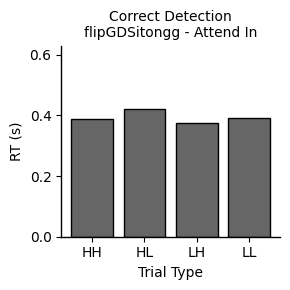

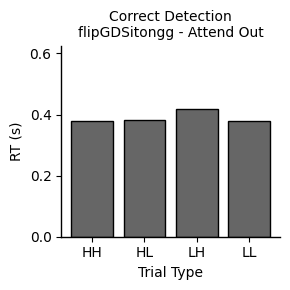

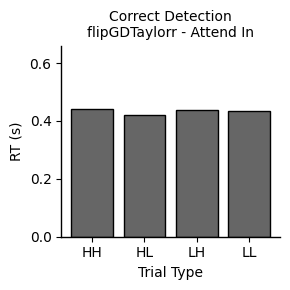

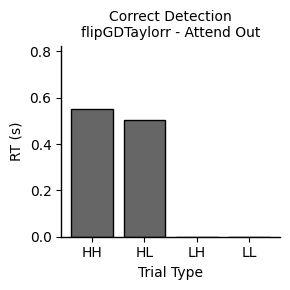

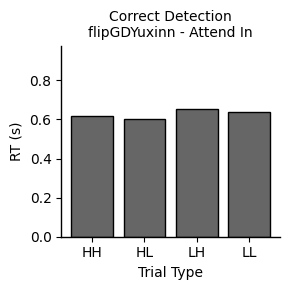

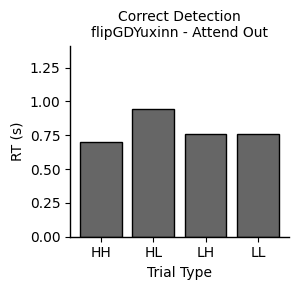

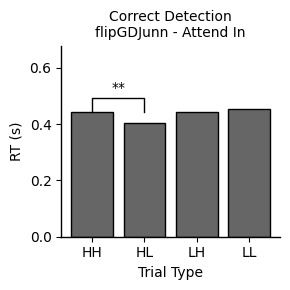

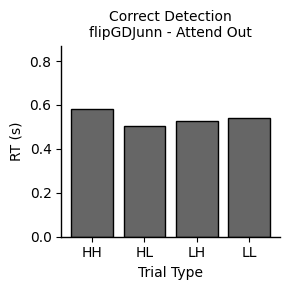

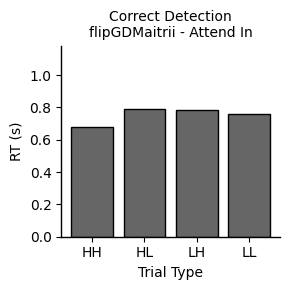

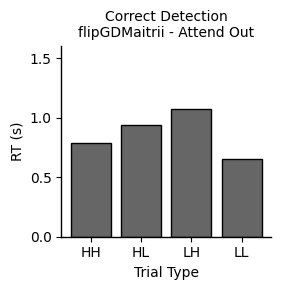

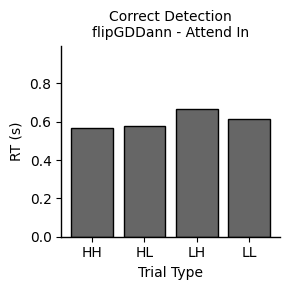

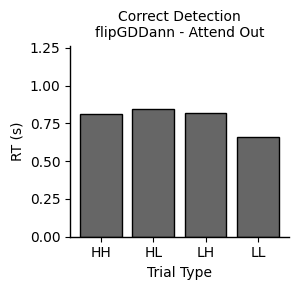

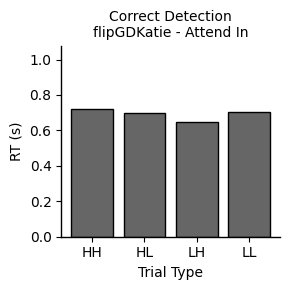

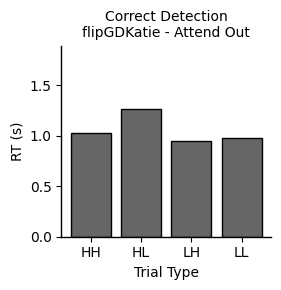

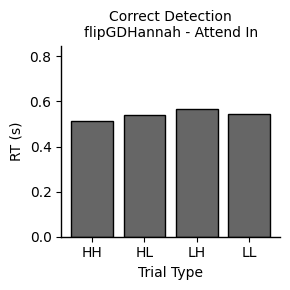

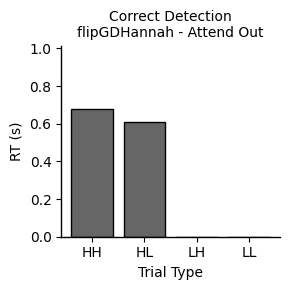

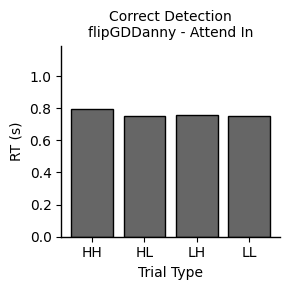

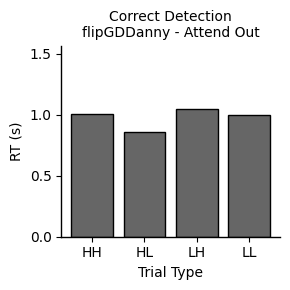

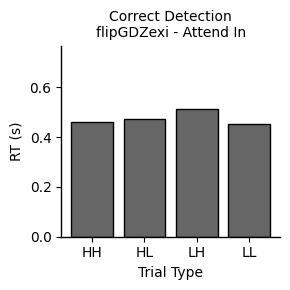

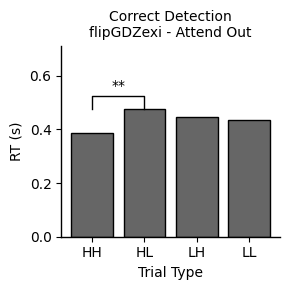

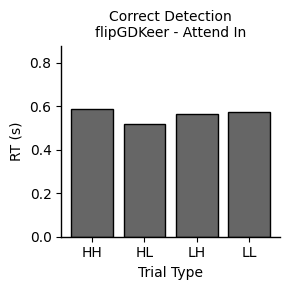

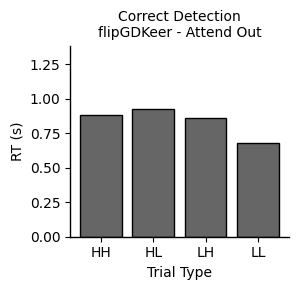

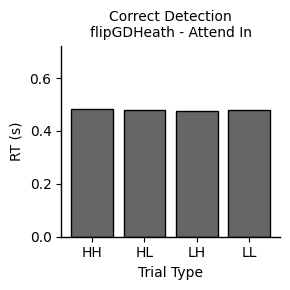

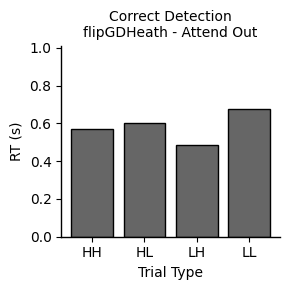

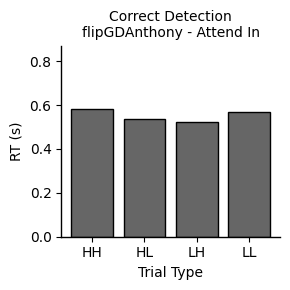

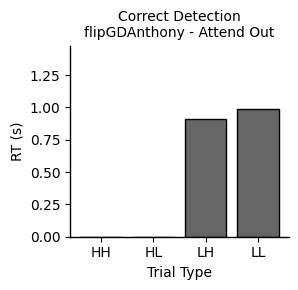

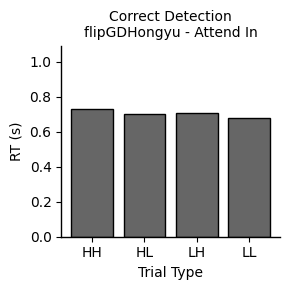

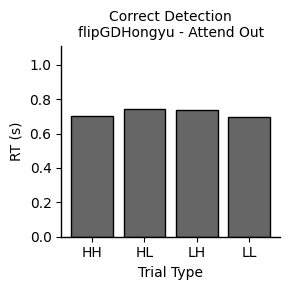

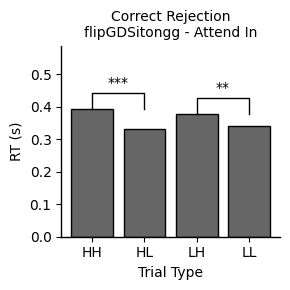

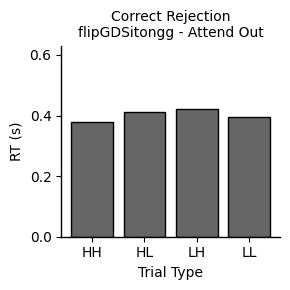

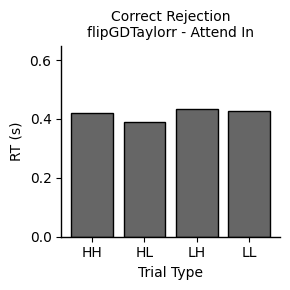

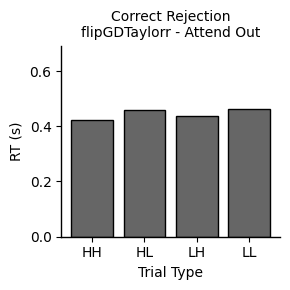

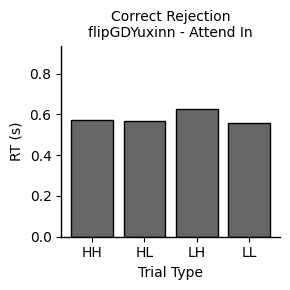

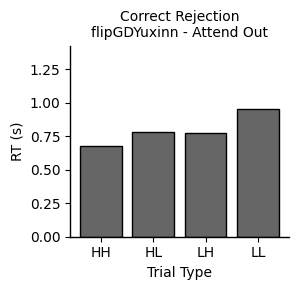

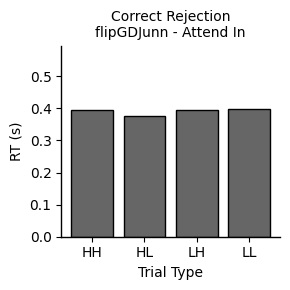

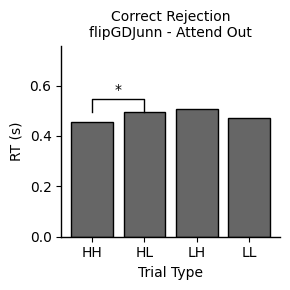

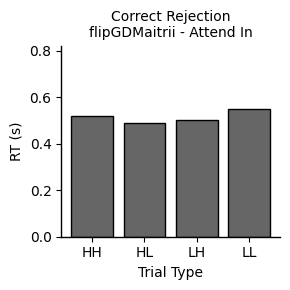

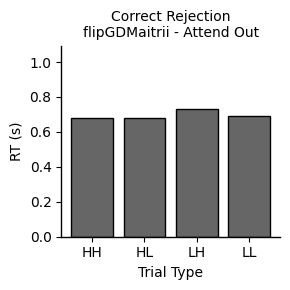

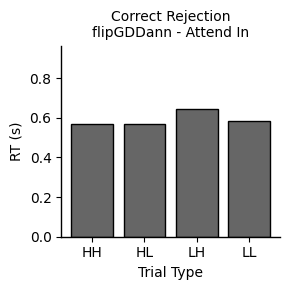

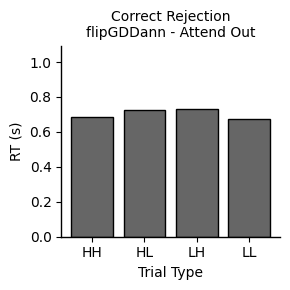

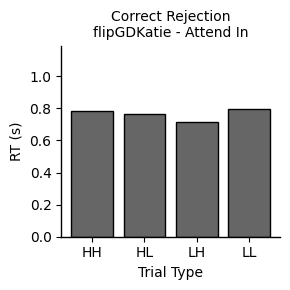

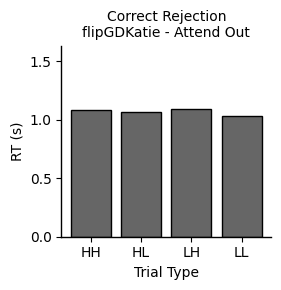

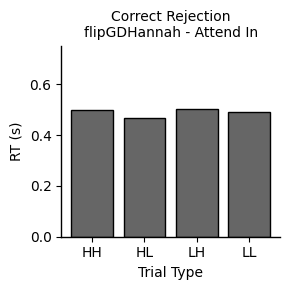

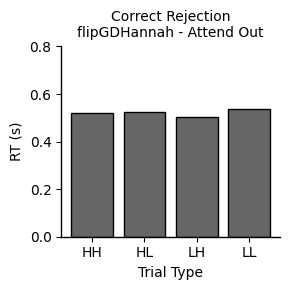

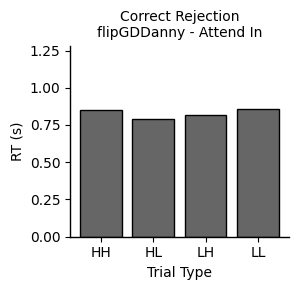

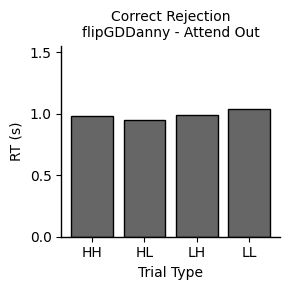

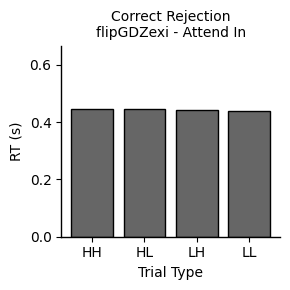

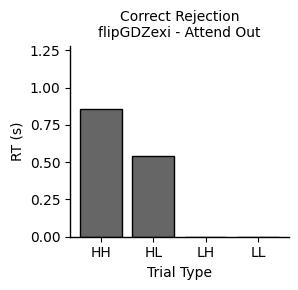

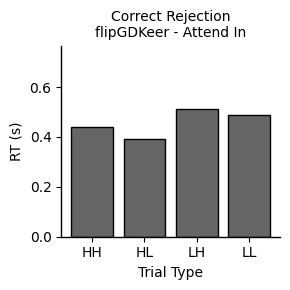

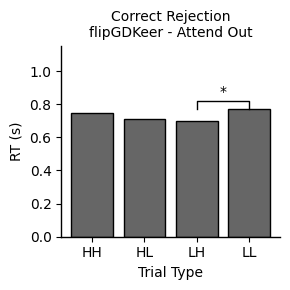

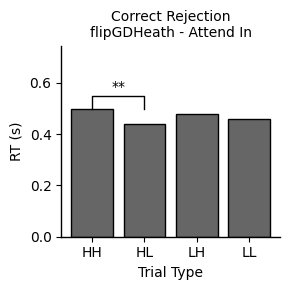

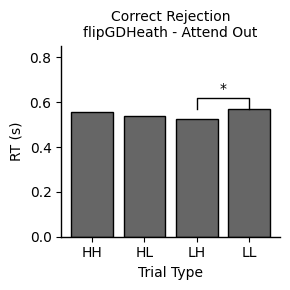

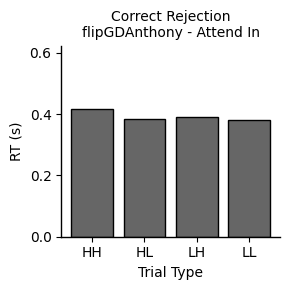

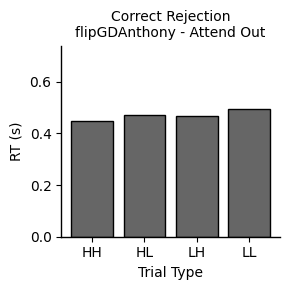

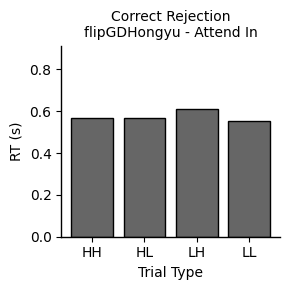

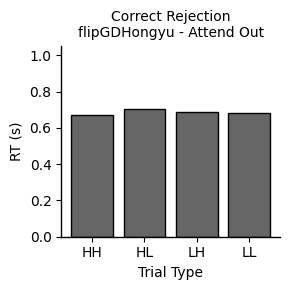

In [4]:
# Filter correct trials (Correctness == "Right")
DC = allDt[allDt["Correctness"] == "Right"]

# Warning from this line:
#
#DC["Attention"] = DC.apply(classify_attention, axis=1)
#
#/tmp/ipykernel_13911/4122936307.py:3: SettingWithCopyWarning: 
#A value is trying to be set on a copy of a slice from a DataFrame.
#Try using .loc[row_indexer,col_indexer] = value instead
# 
# My fix below
DC.insert(0, "Attention", DC.apply(classify_attention, axis=1))


fixed_trial_order = ["HH", "HL", "LH", "LL"]
comparison_pairs = [("HH", "HL"), ("LH", "LL")]
pairing_keys = ["Prefix", "Type", "ImagePairIndex", "StimTestType", "StimChangeType"]



# === Step 5: Split and Plot ===
cd_data = DC[(DC["Correctness"] == "Right") & (DC["StimChangeTF"] != 0)]
cr_data = DC[(DC["Correctness"] == "Right") & (DC["StimChangeTF"] == 0)]

plot_all_subjects_wilcoxon("Correct Detection", cd_data)
plot_all_subjects_wilcoxon("Correct Rejection", cr_data)

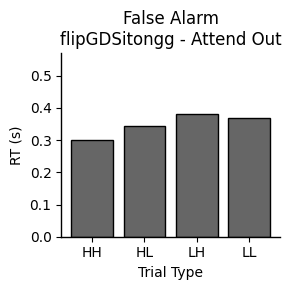

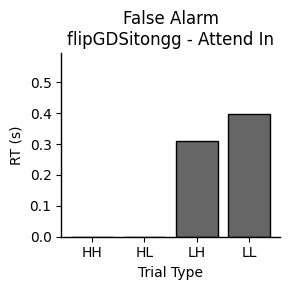

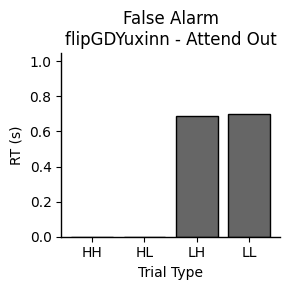

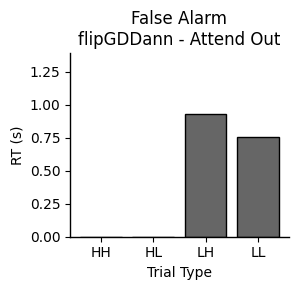

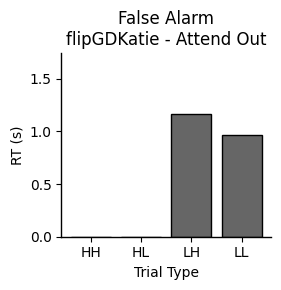

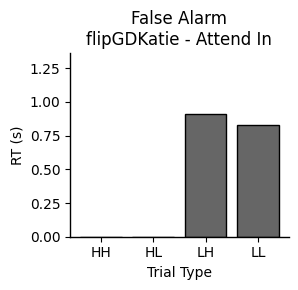

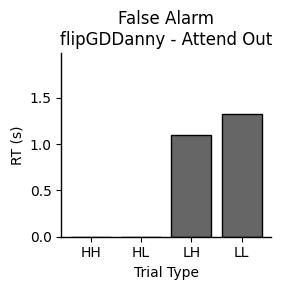

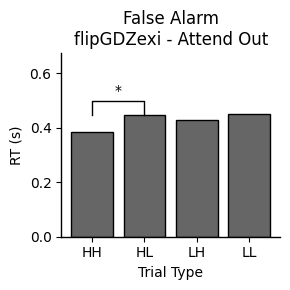

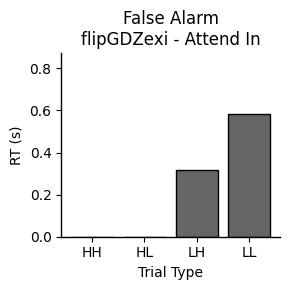

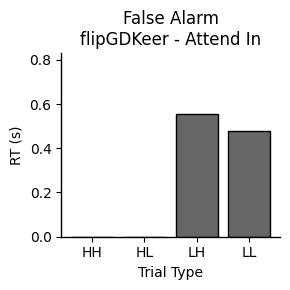

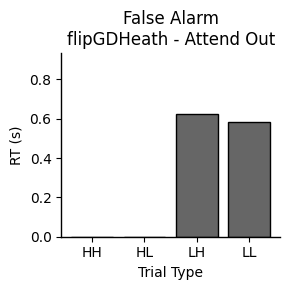

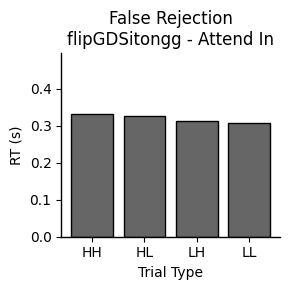

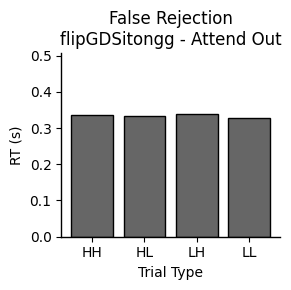

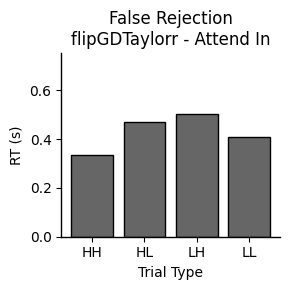

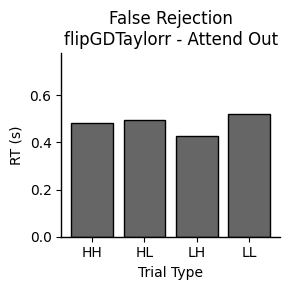

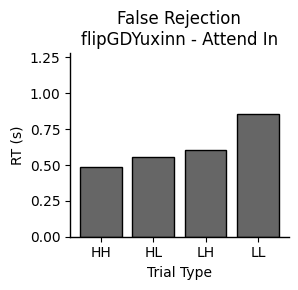

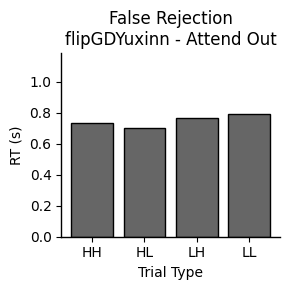

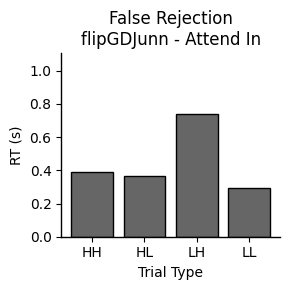

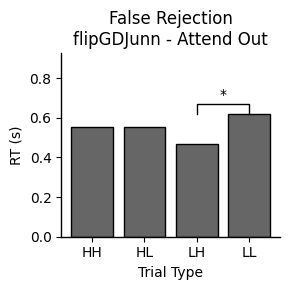

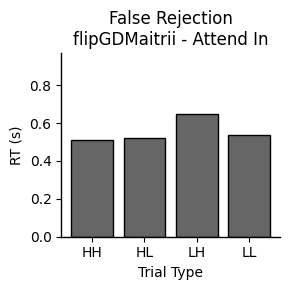

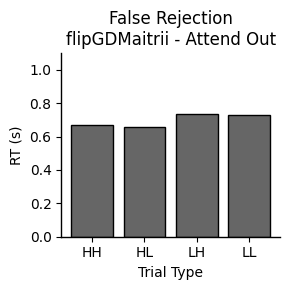

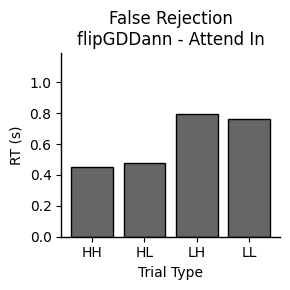

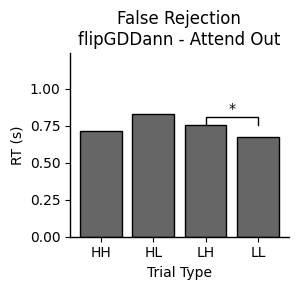

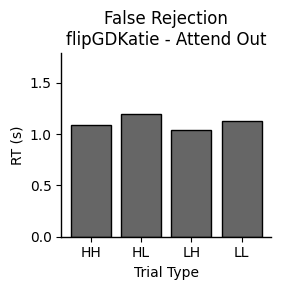

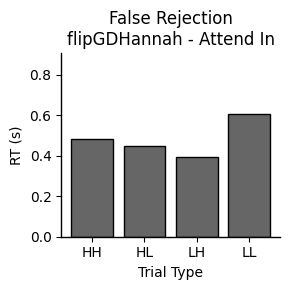

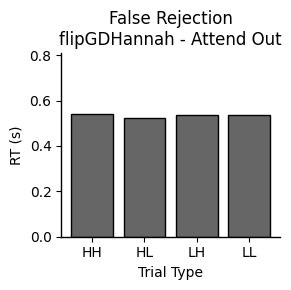

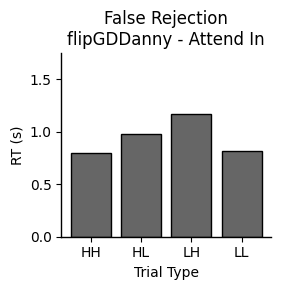

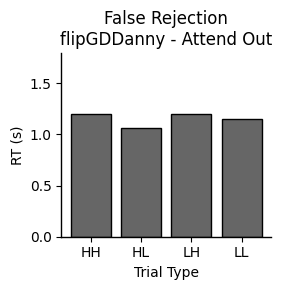

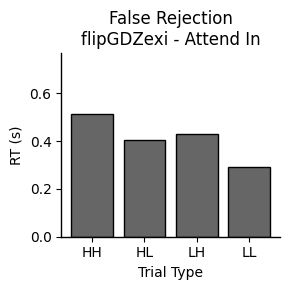

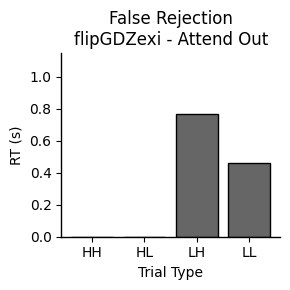

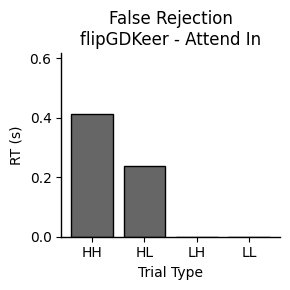

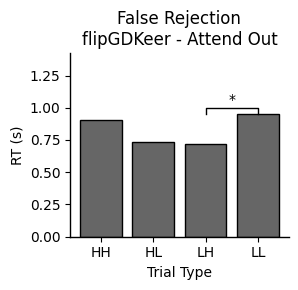

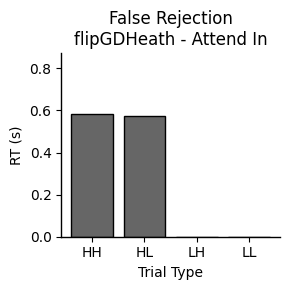

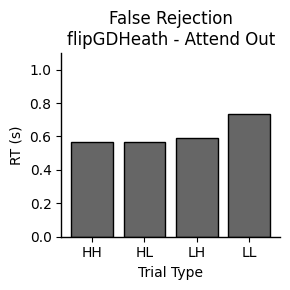

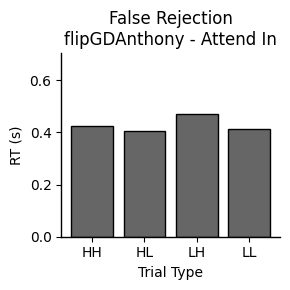

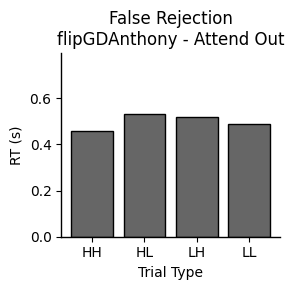

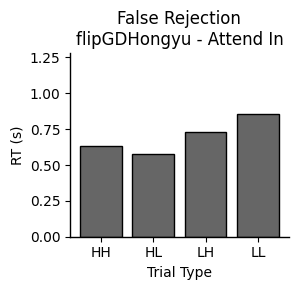

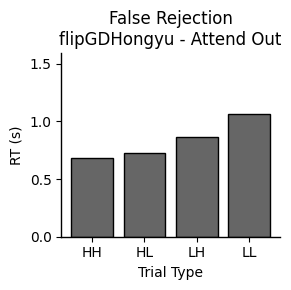

In [5]:
# Step 1: Filter wrong trials from atD
wrong_trials = atD[atD["Correctness"] == "Wrong"].copy()

# Step 2: Split by trial type
DWHH = wrong_trials[wrong_trials["sciTrialType"] == "HH"]
DWHL = wrong_trials[wrong_trials["sciTrialType"] == "HL"]
DWLH = wrong_trials[wrong_trials["sciTrialType"] == "LH"]
DWLL = wrong_trials[wrong_trials["sciTrialType"] == "LL"]

# Step 3: Define pairing keys
pair_keys = ["Prefix", "Type", "ImagePairIndex", "StimTestType", "StimChangeType"]

# Step 4: Inner join HH with HL, and LH with LL
HH_HL_matched = pd.merge(
    DWHH[pair_keys + ["Rows", "ReactionTime"]],
    DWHL[pair_keys + ["Rows", "ReactionTime"]],
    on=pair_keys,
    suffixes=("_HH", "_HL")
)

LH_LL_matched = pd.merge(
    DWLH[pair_keys + ["Rows", "ReactionTime"]],
    DWLL[pair_keys + ["Rows", "ReactionTime"]],
    on=pair_keys,
    suffixes=("_LH", "_LL")
)

# Step 5: Extract only the matched trials from original wrong_trials
matched_row_ids = (
    HH_HL_matched["Rows_HH"].tolist() + HH_HL_matched["Rows_HL"].tolist() +
    LH_LL_matched["Rows_LH"].tolist() + LH_LL_matched["Rows_LL"].tolist()
)

DW_filtered = wrong_trials[wrong_trials["Rows"].isin(matched_row_ids)].copy()


DW_filtered["Attention"] = DW_filtered.apply(classify_attention, axis=1)

# Step 3: Plot Parameters
fixed_trial_order = ["HH", "HL", "LH", "LL"]
comparison_pairs = [("HH", "HL"), ("LH", "LL")]
pairing_keys = ["Prefix", "Type", "ImagePairIndex", "StimTestType", "StimChangeType"]



# Step 6: Split by RT type and plot
false_alarm_data = DW_filtered[DW_filtered["StimChangeTF"] == 0]
false_reject_data = DW_filtered[DW_filtered["StimChangeTF"] != 0]

plot_rt_by_type("False Alarm", false_alarm_data)
plot_rt_by_type("False Rejection", false_reject_data)

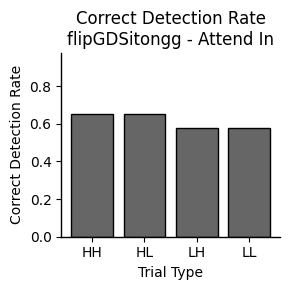

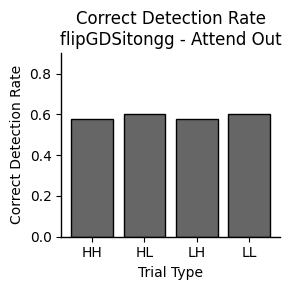

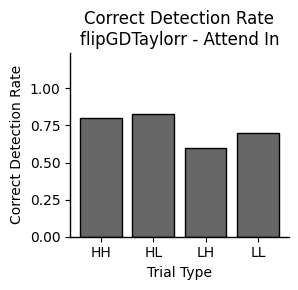

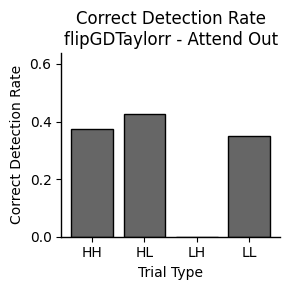

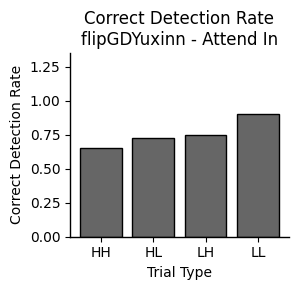

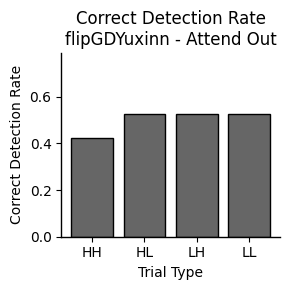

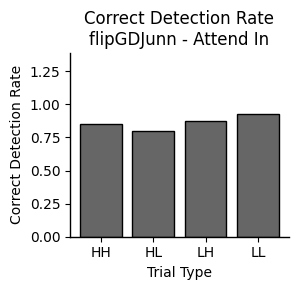

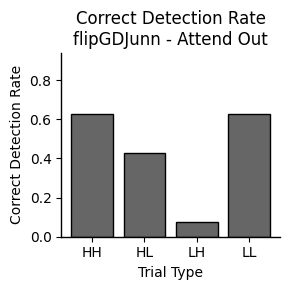

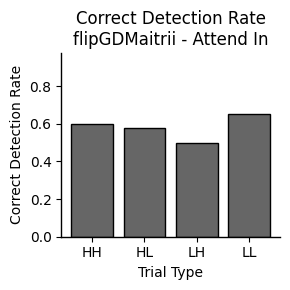

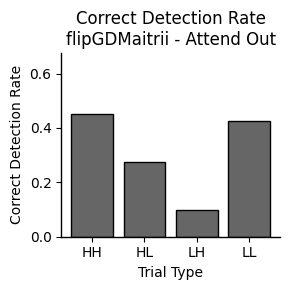

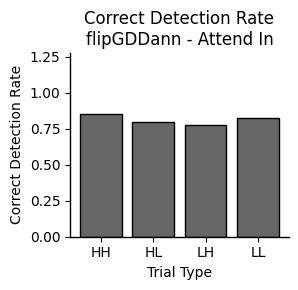

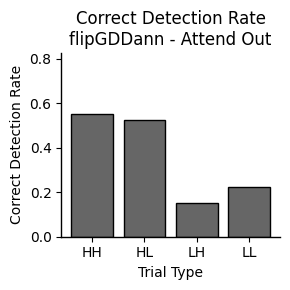

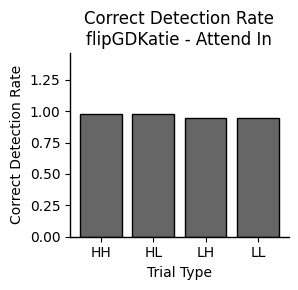

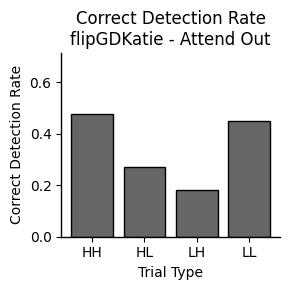

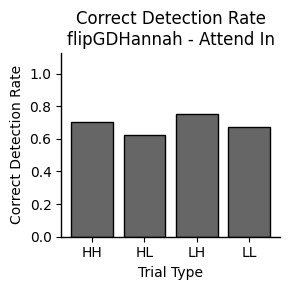

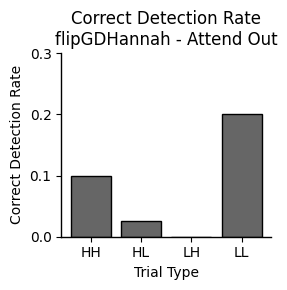

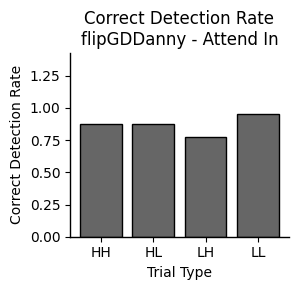

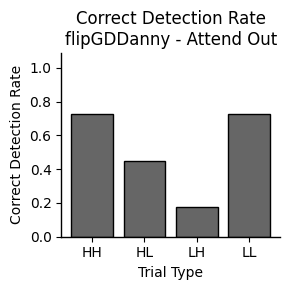

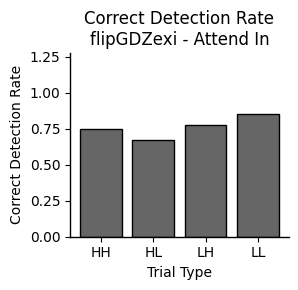

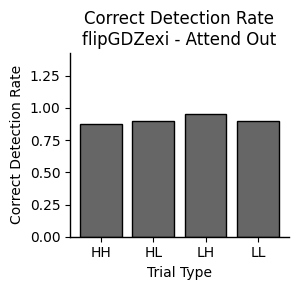

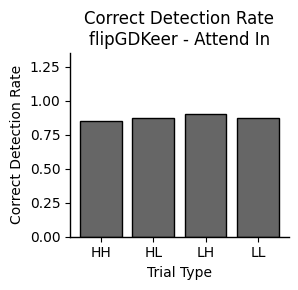

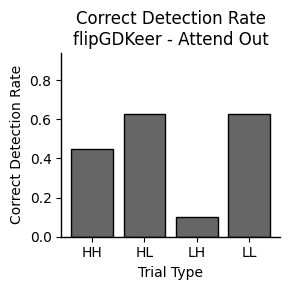

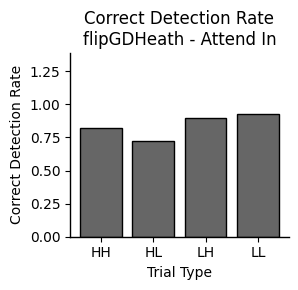

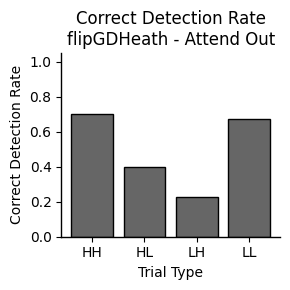

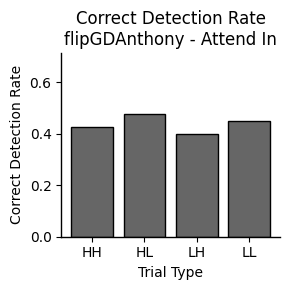

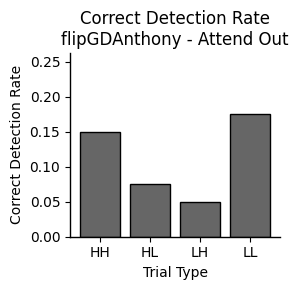

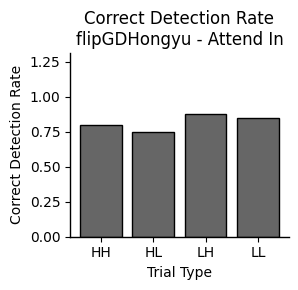

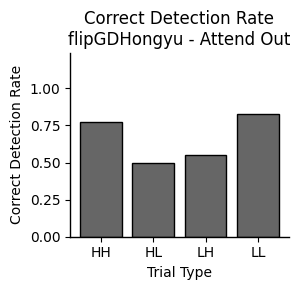

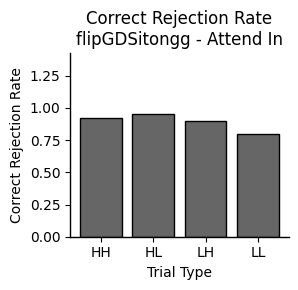

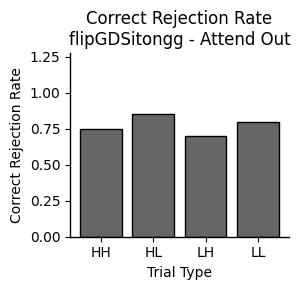

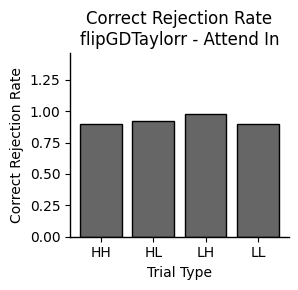

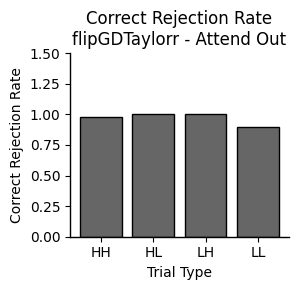

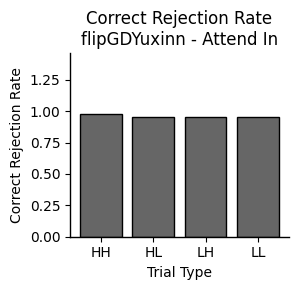

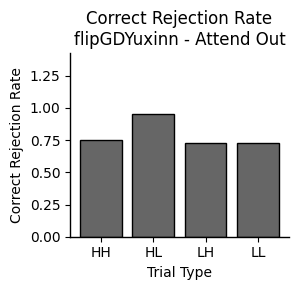

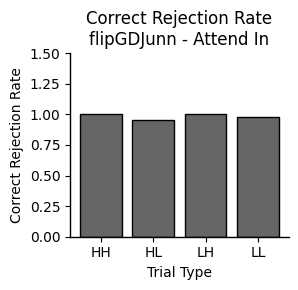

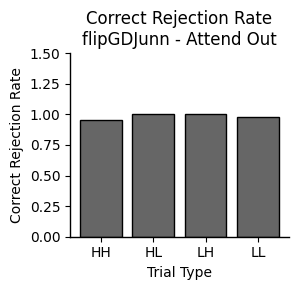

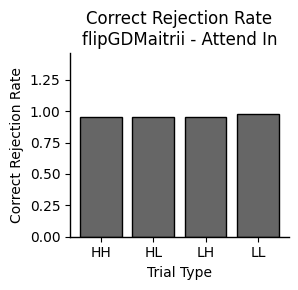

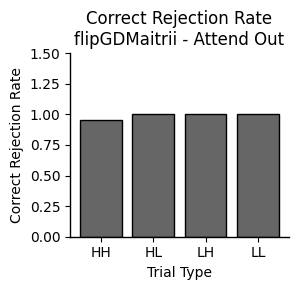

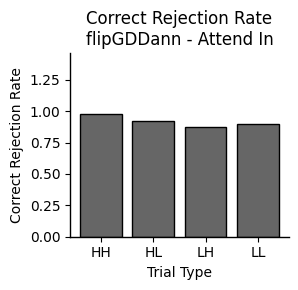

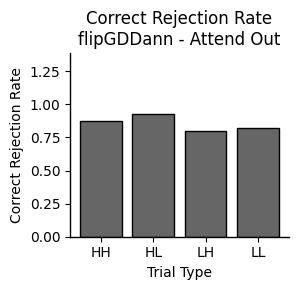

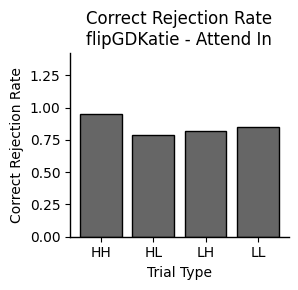

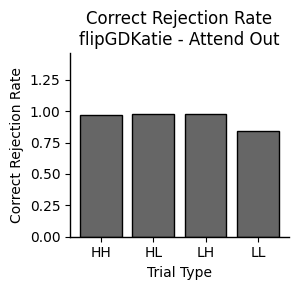

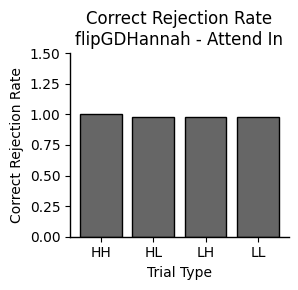

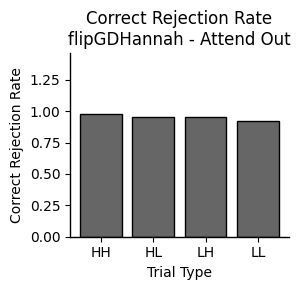

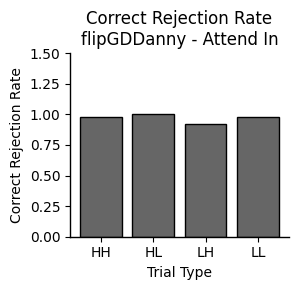

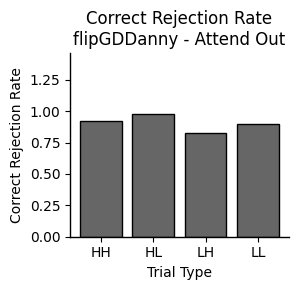

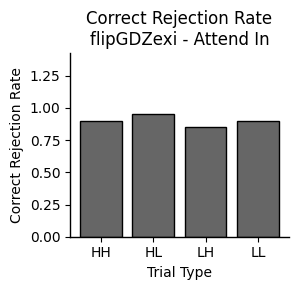

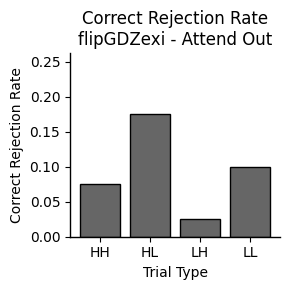

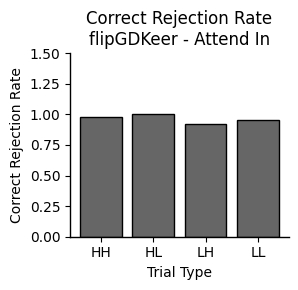

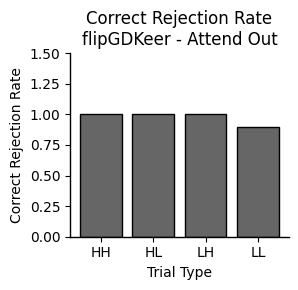

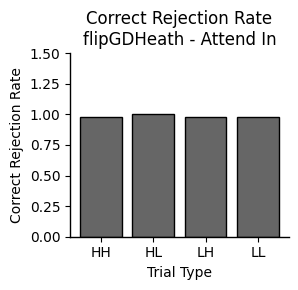

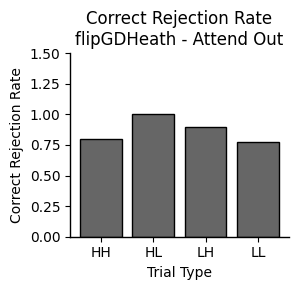

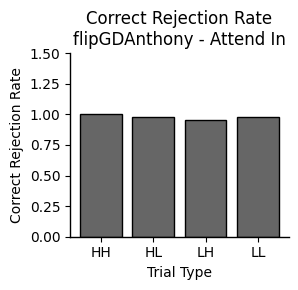

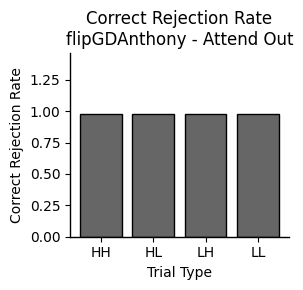

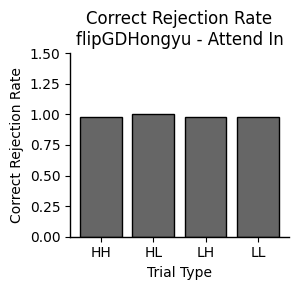

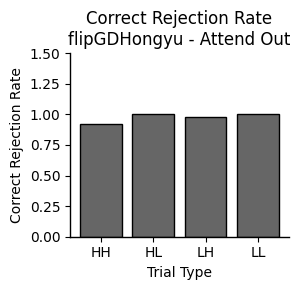

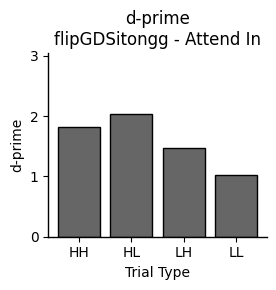

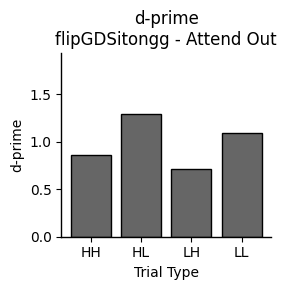

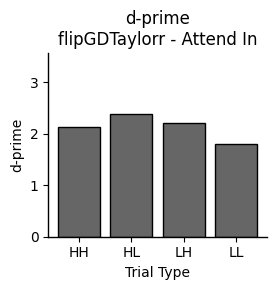

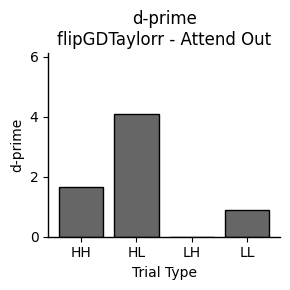

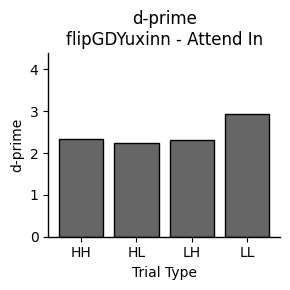

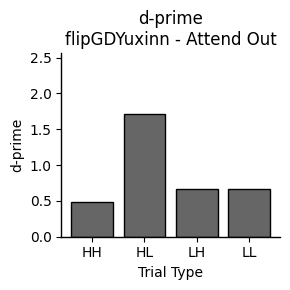

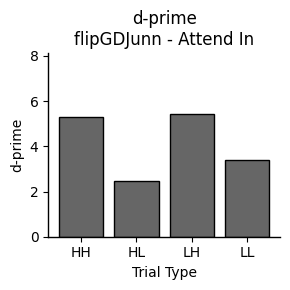

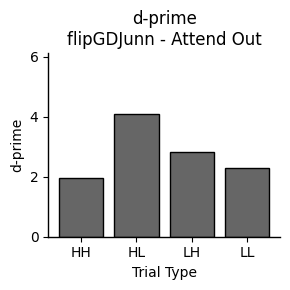

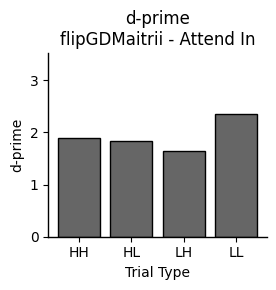

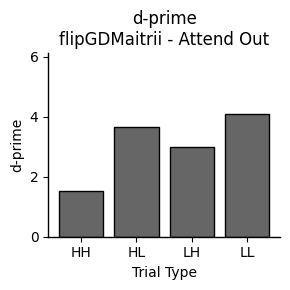

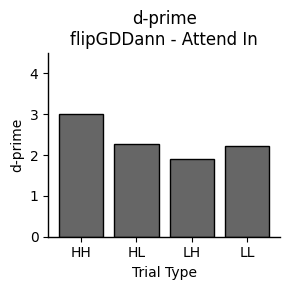

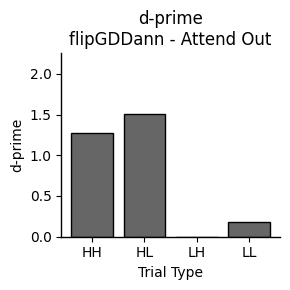

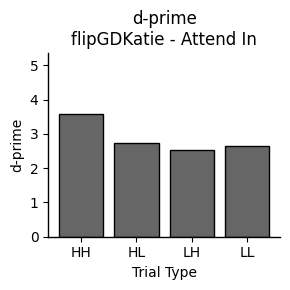

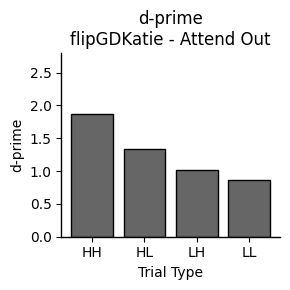

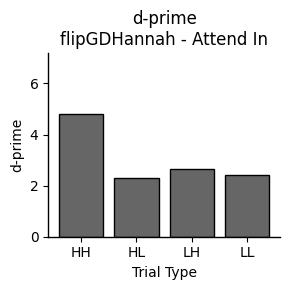

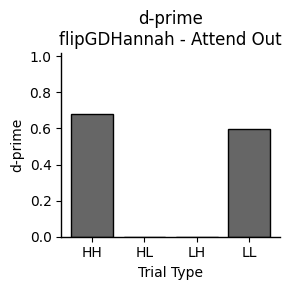

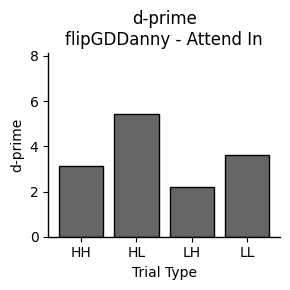

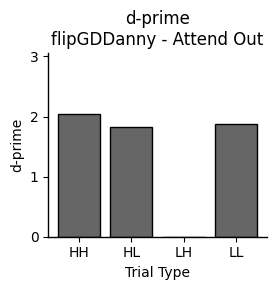

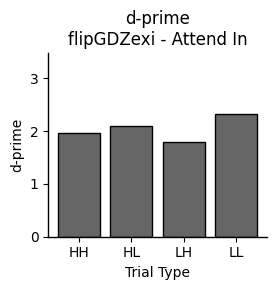

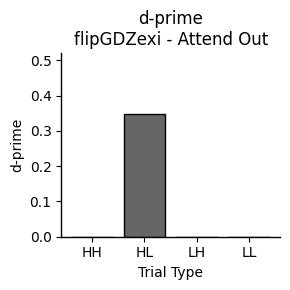

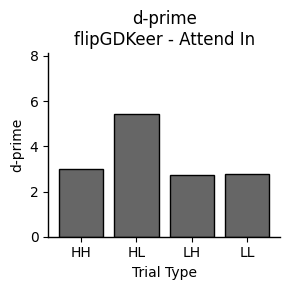

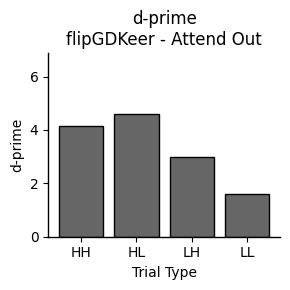

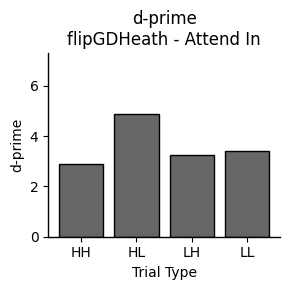

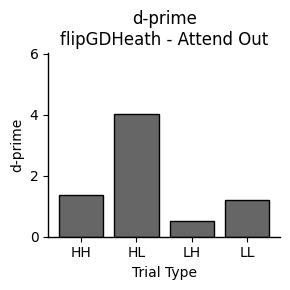

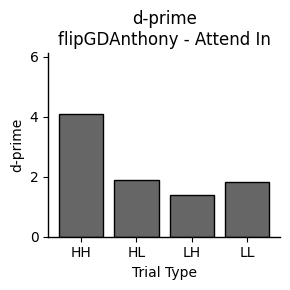

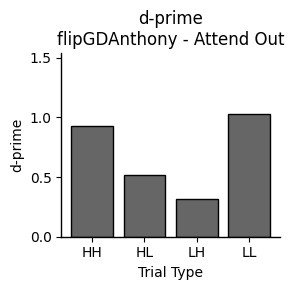

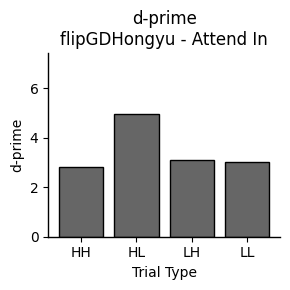

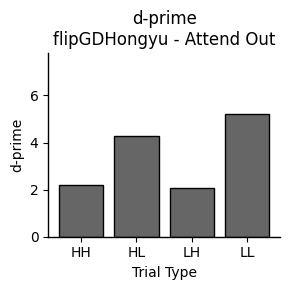

In [6]:
atD["Attention"] = atD.apply(classify_attention, axis=1)




# Step 5: Compute metrics
subjects = atD["Prefix"].unique()
trial_types = ["HH", "HL", "LH", "LL"]
detection_rate = {}
rejection_rate = {}
dprime_values = {}

for subject in subjects:
    subject_data = atD[atD["Prefix"] == subject]
    for attention in ["Attend In", "Attend Out"]:
        subset = subject_data[subject_data["Attention"] == attention]

        det_rate_by_type = {}
        rej_rate_by_type = {}
        dprime_by_type = {}

        for ttype in trial_types:
            trials = subset[subset["sciTrialType"] == ttype]

            detect_trials = trials[trials["StimChangeTF"] != 0]
            detect_right = detect_trials[detect_trials["Correctness"] == "Right"]
            reject_trials = trials[trials["StimChangeTF"] == 0]
            reject_right = reject_trials[reject_trials["Correctness"] == "Right"]

            hit_rate = len(detect_right) / len(detect_trials) if len(detect_trials) > 0 else np.nan
            fa_rate = 1 - (len(reject_right) / len(reject_trials)) if len(reject_trials) > 0 else np.nan

            if len(detect_trials) > 0:
                det_rate_by_type[ttype] = hit_rate
            if len(reject_trials) > 0:
                rej_rate_by_type[ttype] = len(reject_right) / len(reject_trials)
            if not np.isnan(hit_rate) and not np.isnan(fa_rate):
                dprime_by_type[ttype] = compute_dprime(hit_rate, fa_rate)

        detection_rate.setdefault(subject, {})[attention] = det_rate_by_type
        rejection_rate.setdefault(subject, {})[attention] = rej_rate_by_type
        dprime_values.setdefault(subject, {})[attention] = dprime_by_type

# Step 6: Plot all metrics
plot_metrics("Correct Detection Rate", detection_rate)
plot_metrics("Correct Rejection Rate", rejection_rate)
plot_metrics("d-prime", dprime_values)

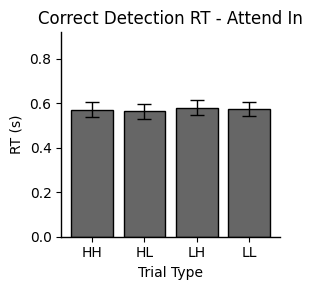

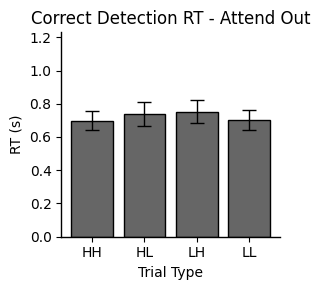

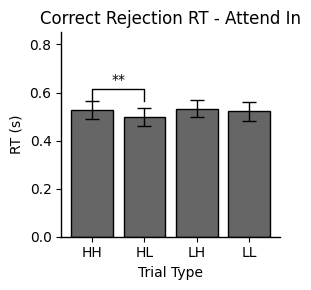

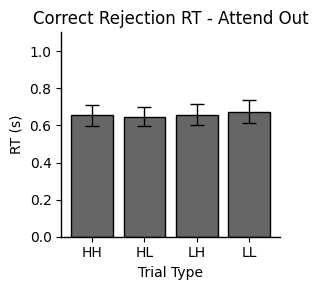

In [7]:
fixed_trial_order = ["HH", "HL", "LH", "LL"]


# === Run all 4 plots ===
plot_rt_group_level_final(DC, stim_tf=1, attention_label="Attend In", title="Correct Detection RT - Attend In")
plot_rt_group_level_final(DC, stim_tf=1, attention_label="Attend Out", title="Correct Detection RT - Attend Out")
plot_rt_group_level_final(DC, stim_tf=0, attention_label="Attend In", title="Correct Rejection RT - Attend In")
plot_rt_group_level_final(DC, stim_tf=0, attention_label="Attend Out", title="Correct Rejection RT - Attend Out")

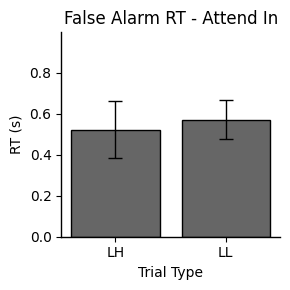

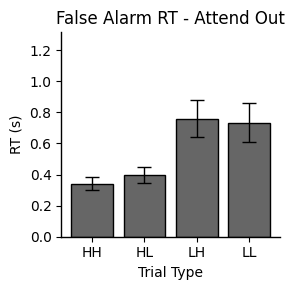

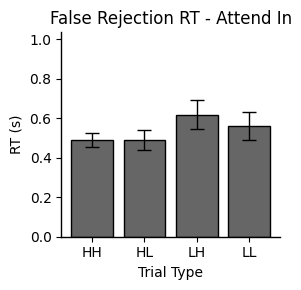

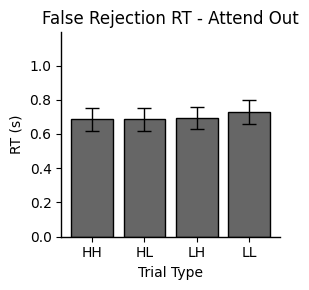

In [8]:
fixed_trial_order = ["HH", "HL", "LH", "LL"]

if "Attention" not in DW_filtered.columns:
    DW_filtered["Attention"] = DW_filtered.apply(classify_attention, axis=1)


# === Generate 4 bar plots ===
plot_rt_group_dw(DW_filtered, stim_tf=0, attention_label="Attend In", title="False Alarm RT - Attend In")
plot_rt_group_dw(DW_filtered, stim_tf=0, attention_label="Attend Out", title="False Alarm RT - Attend Out")
plot_rt_group_dw(DW_filtered, stim_tf=1, attention_label="Attend In", title="False Rejection RT - Attend In")
plot_rt_group_dw(DW_filtered, stim_tf=1, attention_label="Attend Out", title="False Rejection RT - Attend Out")

In [9]:
subset=atD[atD["Attention"] == "Attend In"]
subjects=subset["Prefix"].unique()
print(subjects)
values_by_type = {tt: [] for tt in fixed_trial_order}
print(values_by_type)
# plot_metric_group_with_stats(atD, metric="Detection", attention_label="Attend In", title="Correct Detection Rate - Attend In", ylabel="Detection Rate")

# # Plotting function
# def plot_metric_group_with_stats(df, metric, attention_label, title, ylabel):
#     subset = df[df["Attention"] == attention_label]
#     subjects = subset["Prefix"].unique()

#     values_by_type = {tt: [] for tt in fixed_trial_order}

#     for subject in subjects:
#         subject_data = subset[subset["Prefix"] == subject]
#         for ttype in fixed_trial_order:
#             trial_data = subject_data[subject_data["sciTrialType"] == ttype]
#             detect_trials = trial_data[trial_data["StimChangeTF"] != 0]
#             detect_right = detect_trials[detect_trials["Correctness"] == "Right"]
#             reject_trials = trial_data[trial_data["StimChangeTF"] == 0]
#             reject_right = reject_trials[reject_trials["Correctness"] == "Right"]

#             if metric == "Detection" and len(detect_trials) > 0:
#                 values_by_type[ttype].append(len(detect_right) / len(detect_trials))
#             elif metric == "Rejection" and len(reject_trials) > 0:
#                 values_by_type[ttype].append(len(reject_right) / len(reject_trials))
#             elif metric == "dprime" and len(detect_trials) > 0 and len(reject_trials) > 0:
#                 hit_rate = len(detect_right) / len(detect_trials)
#                 fa_rate = 1 - (len(reject_right) / len(reject_trials))
#                 values_by_type[ttype].append(compute_dprime(hit_rate, fa_rate))

#     means = [np.mean(values_by_type[t]) if values_by_type[t] else np.nan for t in fixed_trial_order]
#     #djs error here without import of 'sem' from scipy.stats, fix is in top cell above
#     errors = [sem(values_by_type[t]) if len(values_by_type[t]) > 1 else np.nan for t in fixed_trial_order]

#     fig, ax = plt.subplots(figsize=(3, 3))
#     ax.bar(
#         fixed_trial_order,
#         means,
#         yerr=errors,
#         capsize=5,
#         color="0.4",
#         edgecolor="black",
#         linewidth=1,
#         error_kw=dict(lw=1, capthick=1, ecolor="black")
#     )

['flipGDSitongg' 'flipGDTaylorr' 'flipGDYuxinn' 'flipGDJunn'
 'flipGDMaitrii' 'flipGDDann' 'flipGDKatie' 'flipGDHannah' 'flipGDDanny'
 'flipGDZexi' 'flipGDKeer' 'flipGDHeath' 'flipGDAnthony' 'flipGDHongyu']
{'HH': [], 'HL': [], 'LH': [], 'LL': []}


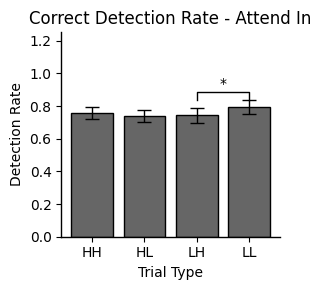

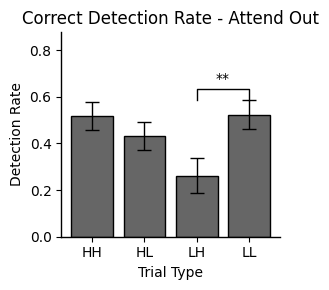

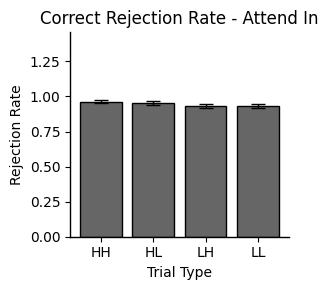

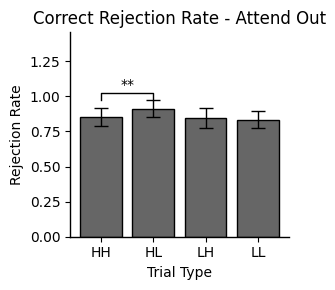

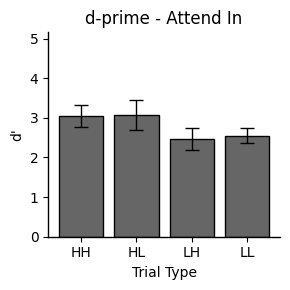

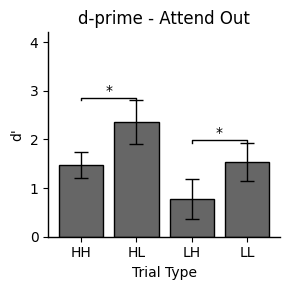

In [10]:
# === Run all 6 plots ===
plot_metric_group_with_stats(atD, metric="Detection", attention_label="Attend In", title="Correct Detection Rate - Attend In", ylabel="Detection Rate")
plot_metric_group_with_stats(atD, metric="Detection", attention_label="Attend Out", title="Correct Detection Rate - Attend Out", ylabel="Detection Rate")

plot_metric_group_with_stats(atD, metric="Rejection", attention_label="Attend In", title="Correct Rejection Rate - Attend In", ylabel="Rejection Rate")
plot_metric_group_with_stats(atD, metric="Rejection", attention_label="Attend Out", title="Correct Rejection Rate - Attend Out", ylabel="Rejection Rate")

plot_metric_group_with_stats(atD, metric="dprime", attention_label="Attend In", title="d-prime - Attend In", ylabel="d'")
plot_metric_group_with_stats(atD, metric="dprime", attention_label="Attend Out", title="d-prime - Attend Out", ylabel="d'")